# NN implemetation with Keras

## Imports

In [37]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


## Utils functions

In [38]:
# Funzione per normalizzare i dati
def normalize(data):
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data)
    return normalized_data


In [39]:
def split_data(data, labels, k=5):
    """
    Divide i dati in k fold.
    
    Args:
        data (np.ndarray | pd.DataFrame): Dati di input.
        labels (np.ndarray | pd.Series): Etichette.
        k (int): Numero di fold.
    
    Returns:
        list: Lista di tuple (fold_data, fold_labels).
    """
    if not isinstance(data, np.ndarray):
        data = data.to_numpy()  # Converte DataFrame in NumPy array
    if not isinstance(labels, np.ndarray):
        labels = labels.to_numpy()  # Converte Series in NumPy array
    
    data = normalize(data)

    fold_size = len(data) // k
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    folds = []

    for i in range(k):
        fold_indices = indices[i * fold_size: (i + 1) * fold_size]
        fold_data = data[fold_indices]
        fold_labels = labels[fold_indices]
        folds.append((fold_data, fold_labels))
    
    return folds

In [40]:
def generate_hyperparameter_combinations(param_ranges):
    """
    Genera tutte le combinazioni di iperparametri basate su range e step specificati.

    :param param_ranges: Dizionario con i nomi degli iperparametri come chiavi.
                         Ogni valore è una tupla (start, stop, step).
    :return: Lista di dizionari con tutte le combinazioni possibili.
    """
    param_values = {
        key: np.arange(start, stop + step, step)
        for key, (start, stop, step) in param_ranges.items()
    }
    
    param_combinations = list(itertools.product(*param_values.values()))
    return [
        dict(zip(param_values.keys(), combination))
        for combination in param_combinations
    ]

## Model creation

In [41]:
def create_nn(input_dim, learning_rate=0.01, hidden_size=6, hidden_layers=1, regularization=0.01, momentum=0.9, alpha=0.01):
    """
    Create a binary classification neural network with Leaky ReLU and configurable parameters.
    
    Parameters:
    - input_dim (int): Number of input features.
    - learning_rate (float): Learning rate for the optimizer.
    - hidden_size (int): Number of nodes in each hidden layer.
    - hidden_layers (int): Number of hidden layers.
    - regularization (float): L2 regularization factor.
    - momentum (float): Momentum for the optimizer.
    - alpha (float): Negative slope coefficient for Leaky ReLU.
    
    Returns:
    - model (tf.keras.Model): Compiled Keras model.
    """
    model = Sequential()
    
    '''
    # Input layer (using Input layer explicitly)
    model.add(Input(shape=(input_dim,)))  # Input layer defined explicitly

    # Hidden layers with ReLU
    for _ in range(hidden_layers):
        model.add(Dense(hidden_size, activation='relu',
                         kernel_regularizer=l2(regularization)
                        ))  # ReLU activation directly in Dense layer

    '''
    # Input layer (using Input layer explicitly)
    model.add(Input(shape=(input_dim,)))  # Input layer defined explicitly
    
    # Hidden layers with Leaky ReLU 
    for _ in range(hidden_layers):
        model.add(Dense(hidden_size, kernel_regularizer=l2(regularization)))
        model.add(LeakyReLU(negative_slope=alpha))  # Updated to use negative_slope
    
    # Output layer (binary classification)
    model.add(Dense(1, activation='sigmoid'))
    
    # Optimizer
    #optimizer = SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)

    #Adam optimizer
    optimizer= Adam(learning_rate=learning_rate)
    
    # Compile the model
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    
    return model

## Double-k-fold cross validation

In [42]:
def double_k_fold_cross_validation(data, labels, in_size = 6, outer_k = 5, inner_k = 5, param_grid=None):
    """
    Implementa una Double K-Fold Cross-Validation

    Args:
        data (np.ndarray): Caratteristiche del dataset.
        labels (np.ndarray): Etichette del dataset.
        outer_k (int): Numero di fold per la validazione esterna.
        inner_k (int): Numero di fold per l'ottimizzazione iperparametri.
        param_grid (list): Lista di dizionari con gli iperparametri da provare.
    
    Returns:
        list: Lista dei punteggi ottenuti per ogni fold esterno.
    """
    outer_scores = []
    outer_params = []
    outer_folds = split_data(data, labels, k=outer_k)
    
    for i in range(outer_k):
        print("Outer fold", i + 1)
        outer_test_data, outer_test_labels = outer_folds[i]
        outer_train_data = np.concatenate([fold[0] for j, fold in enumerate(outer_folds) if j != i])
        outer_train_labels = np.concatenate([fold[1] for j, fold in enumerate(outer_folds) if j != i])
        
        best_params = {}
        best_score = -np.inf
        
        # Validazione interna per ottimizzazione iperparametri
        inner_folds = split_data(outer_train_data, outer_train_labels, k=inner_k)

        for params in param_grid:
            inner_scores = []
            
            for j in range(inner_k):
                inner_val_data, inner_val_labels = inner_folds[j]
                inner_train_data = np.concatenate([fold[0] for l, fold in enumerate(inner_folds) if l != j])
                inner_train_labels = np.concatenate([fold[1] for l, fold in enumerate(inner_folds) if l != j])
                # Creazione della rete neurale
                model = create_nn(input_dim = in_size, learning_rate=params['learning_rate'], hidden_size = params['hidden_size'], 
                                  hidden_layers = params['hidden_layers'], regularization=params['regularization'], momentum=params['momentum'], alpha=params['alpha'])

                # Allena il modello e ottieni la cronologia (history)
                history = model.fit(inner_train_data, inner_train_labels, epochs=params['epochs'],
                    batch_size=params['batch_size'],
                    validation_data=(inner_val_data, inner_val_labels), verbose=0)
                    
                inner_scores.append(max(history.history['val_accuracy']))
            
            avg_score = np.mean(inner_scores)
            if avg_score > best_score:
                best_score = avg_score
                best_params = params
        
        # Addestramento finale sul set di train esterno
        final_model = create_nn(input_dim = in_size, 
                                learning_rate=best_params['learning_rate'],
                                hidden_size = best_params['hidden_size'], 
                                hidden_layers = best_params['hidden_layers'],
                                regularization=best_params['regularization'],
                                momentum=best_params['momentum'],
                                alpha=best_params['alpha'])
        
        
        history = final_model.fit(outer_train_data, outer_train_labels, epochs=best_params['epochs'],
                    batch_size=best_params['batch_size'], validation_data=(outer_test_data, outer_test_labels), verbose=0)
        outer_scores.append(max(history.history['val_accuracy']))
        outer_params.append(best_params)
    
    return outer_scores, outer_params

## K-fold cross validation

In [43]:
def k_fold_cross_validation(data, labels, in_size, k=5, params=None):
    """
    Implementa una K-Fold Cross-Validation con Early Stopping
    """
    scores = []
    folds = split_data(data, labels, k=k)

    # EarlyStopping callback con pazienza
    early_stopping = EarlyStopping(monitor='val_loss', patience=params['patience'], restore_best_weights=True)

    for i in range(k):
        # Creazione della rete neurale
        model = create_nn(input_dim=in_size, 
                          learning_rate=params['learning_rate'], 
                          hidden_size=params['hidden_size'], 
                          hidden_layers=params['hidden_layers'], 
                          regularization=params['regularization'], 
                          momentum=params['momentum'], 
                          alpha=params['alpha'])

        test_data, test_labels = folds[i]
        train_data = np.concatenate([fold[0] for j, fold in enumerate(folds) if j != i])
        train_labels = np.concatenate([fold[1] for j, fold in enumerate(folds) if j != i])

        # Addestramento con EarlyStopping
        history = model.fit(train_data, train_labels, 
                            epochs=params['epochs'], 
                            batch_size=params['batch_size'], 
                            validation_data=(test_data, test_labels),
                            verbose=0, 
                            callbacks=[early_stopping])

        # Prendi il miglior score (l'accuratezza di validazione massima)
        score = max(history.history['val_accuracy'])
        scores.append(score)

    avg_score = np.mean(scores)

    # Training finale sul dataset completo
    #train_data = np.concatenate([fold[0] for fold in folds])
    #train_labels = np.concatenate([fold[1] for fold in folds])

    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)


    model = create_nn(input_dim=in_size, 
                      learning_rate=params['learning_rate'], 
                      hidden_size=params['hidden_size'], 
                      hidden_layers=params['hidden_layers'], 
                      regularization=params['regularization'], 
                      momentum=params['momentum'], 
                      alpha=params['alpha'])

    # Addestramento finale con EarlyStopping
    history = model.fit(X_train, y_train, 
                        epochs=params['epochs'], 
                        batch_size=params['batch_size'], 
                        validation_data=(X_val, y_val),
                        verbose=0, 
                        callbacks=[early_stopping])

    return avg_score, history, model

## Data loading

In [44]:
# Carica i file di addestramento e test per ciascun dataset dal percorso specificato
monk1_train = pd.read_csv('../Datasets/Monks/monks-1.train', sep='\s+', header=None)
monk1_test = pd.read_csv('../Datasets/Monks/monks-1.test', sep='\s+', header=None)

monk2_train = pd.read_csv('../Datasets/Monks/monks-2.train', sep='\s+', header=None)
monk2_test = pd.read_csv('../Datasets/Monks/monks-2.test', sep='\s+', header=None)

monk3_train = pd.read_csv('../Datasets/Monks/monks-3.train', sep='\s+', header=None)
monk3_test = pd.read_csv('../Datasets/Monks/monks-3.test', sep='\s+', header=None)


# Separazione tra features e labels per monk1
X1_train = monk1_train.iloc[:, 1:7].values  # Caratteristiche (features)
y1_train = monk1_train.iloc[:, 0].values   # Etichette (labels)

X1_test = monk1_test.iloc[:, 1:7].values
y1_test = monk1_test.iloc[:, 0].values

# Separazione tra features e labels per monk2
X2_train = monk2_train.iloc[:, 1:7].values
y2_train = monk2_train.iloc[:, 0].values

X2_test = monk2_test.iloc[:, 1:7].values
y2_test = monk2_test.iloc[:, 0].values

# Separazione tra features e labels per monk3
X3_train = monk3_train.iloc[:, 1:7].values
y3_train = monk3_train.iloc[:, 0].values

X3_test = monk3_test.iloc[:, 1:7].values
y3_test = monk3_test.iloc[:, 0].values

## Greed search

In [ ]:
# Definisce i parametri della rete neurale
input_size = 6
output_size = 1

# Definizione dei range degli iperparametri
param_ranges = {
    "learning_rate": (0.5, 0.8, 0.1),  # Da 0.01 a 0.5 con step di 0.05
    "epochs": (50, 50, 1),                   # Da 0 a 10 con step di 1
    "batch_size": (4, 4, 1),             # Da 8 a 32 con step di 8
    "hidden_size": (1, 3, 1),           # Da 32 a 128 con step di 32
    "hidden_layers": (1, 1, 1),             # Da 1 a 3 con step di 1
    "momentum": (0.8, 0.8, 0.1),          # Da 0.9 a 0.99 con step di 0.01
    "regularization": (0.0001, 0.001, 0.0005),             # Da 0.0 a 0.1 con step di 0.05
    "alpha": (0.01, 0.01, 0.01),             # Da 0.01 a 0.1 con step di 0.05
    "patience": (5, 5, 1)            # Da 5 a 15 con step di 5
}

#start_time = time.time()
print("Generazione delle combinazioni di iperparametri...")
param_grid = []
param_grid = generate_hyperparameter_combinations(param_ranges)
#end_time = time.time()

#execution_time = end_time - start_time
#print(f"Tempo di esecuzione di generate_hyperparameter_combinations: {execution_time} secondi")
'''
scores,params = double_k_fold_cross_validation(X1_train, y1_train, input_size, outer_k=5, inner_k=3, param_grid=param_grid)
for i in range(len(scores)):
    print(f"Fold {i + 1}: {scores[i]}")
    print(f"  params: {params[i]}")
print("Punteggio medio:", np.mean(scores))
'''

best_scores = []  # Usa una lista normale per memorizzare i punteggi
best_params_list = []  # Lista per le configurazioni
best_models = []  # Lista per i modelli
best_histories = []  # Lista per la storia di allenamento

# Seleziona 100 elementi a caso senza rimpiazzamento
#param_grid = np.random.choice(param_grid, size=12, replace=False)

for params in param_grid:
    print("--------------------------------------------------")
    print(f"Testing params: {params}")
    score, history, model = k_fold_cross_validation(X1_train, y1_train, input_size, k=10, params=params)
    print(f"Score : {score}")

    # Aggiungi i risultati alla lista
    best_scores.append(score)
    best_params_list.append(params)
    best_models.append(model)
    best_histories.append(history)

    # Ordina la lista dei punteggi e mantieni solo i migliori 10
    sorted_indices = np.argsort(best_scores)[::-1]  # Ordina i punteggi in ordine decrescente
    best_scores = [best_scores[i] for i in sorted_indices][:10]  # Usa la lista e mantieni i top 10
    best_params_list = [best_params_list[i] for i in sorted_indices][:10]
    best_models = [best_models[i] for i in sorted_indices][:10]
    best_histories = [best_histories[i] for i in sorted_indices][:10]

print("--------------------END GREED SEARCH------------------------------")

# Ora hai i 10 migliori risultati
print("Top 10 best scores:")
print(best_scores)
print("Top 10 best params:")
print(best_params_list)


Generazione delle combinazioni di iperparametri...
--------------------------------------------------
Testing params: {'learning_rate': 0.5, 'epochs': 50, 'batch_size': 4, 'hidden_size': 1, 'hidden_layers': 1, 'momentum': 0.8, 'regularization': 0.0001, 'alpha': 0.01, 'patience': 10}
Score : 0.7916666626930237
--------------------------------------------------
Testing params: {'learning_rate': 0.5, 'epochs': 50, 'batch_size': 4, 'hidden_size': 1, 'hidden_layers': 1, 'momentum': 0.8, 'regularization': 0.0006000000000000001, 'alpha': 0.01, 'patience': 10}
Score : 0.7833333373069763
--------------------------------------------------
Testing params: {'learning_rate': 0.5, 'epochs': 50, 'batch_size': 4, 'hidden_size': 1, 'hidden_layers': 1, 'momentum': 0.8, 'regularization': 0.0011, 'alpha': 0.01, 'patience': 10}
Score : 0.7499999940395355
--------------------------------------------------
Testing params: {'learning_rate': 0.5, 'epochs': 50, 'batch_size': 4, 'hidden_size': 2, 'hidden_layers'

In [46]:
def plot_training_history(history):
    """
    Plot training and validation loss and accuracy from a model's history, 
    adding the parameters as a title.

    Parameters:
    - history: History object returned by model.fit().
    - params: Dictionary containing the model parameters.
    """

    # Estrai dati dalla history
    train_loss = history.history['loss']
    val_loss = history.history.get('val_loss', [])
    train_acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    
    epochs = range(1, len(train_loss) + 1)  # Numero di epoche

    # Grafico della Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Grafico dell'Accuracy
    plt.subplot(1, 2, 2)
    if train_acc:
        plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

{'learning_rate': 0.5, 'epochs': 50, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.8, 'regularization': 0.0006000000000000001, 'alpha': 0.01, 'patience': 10}


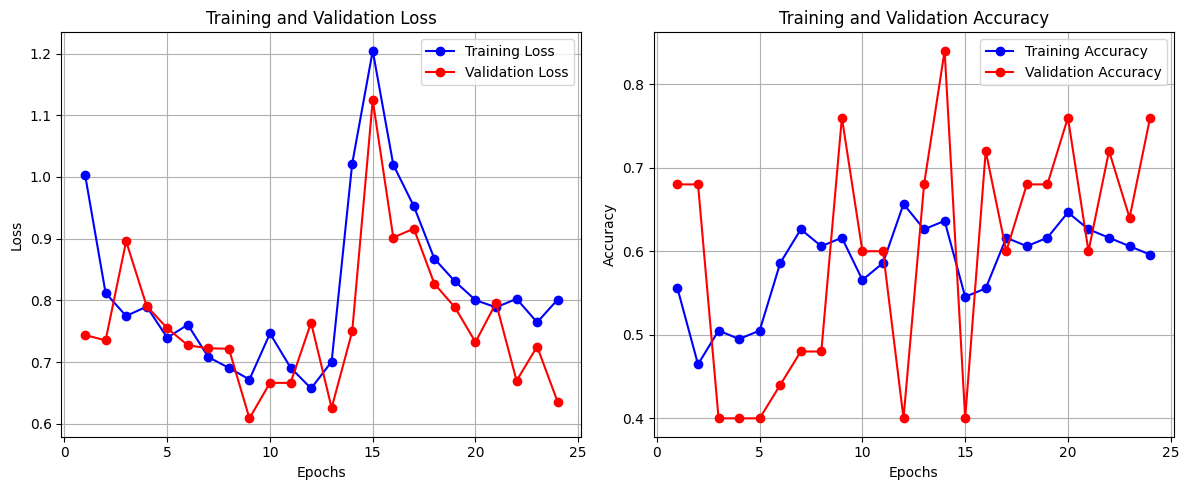

{'learning_rate': 0.5, 'epochs': 50, 'batch_size': 4, 'hidden_size': 2, 'hidden_layers': 1, 'momentum': 0.8, 'regularization': 0.0001, 'alpha': 0.01, 'patience': 10}


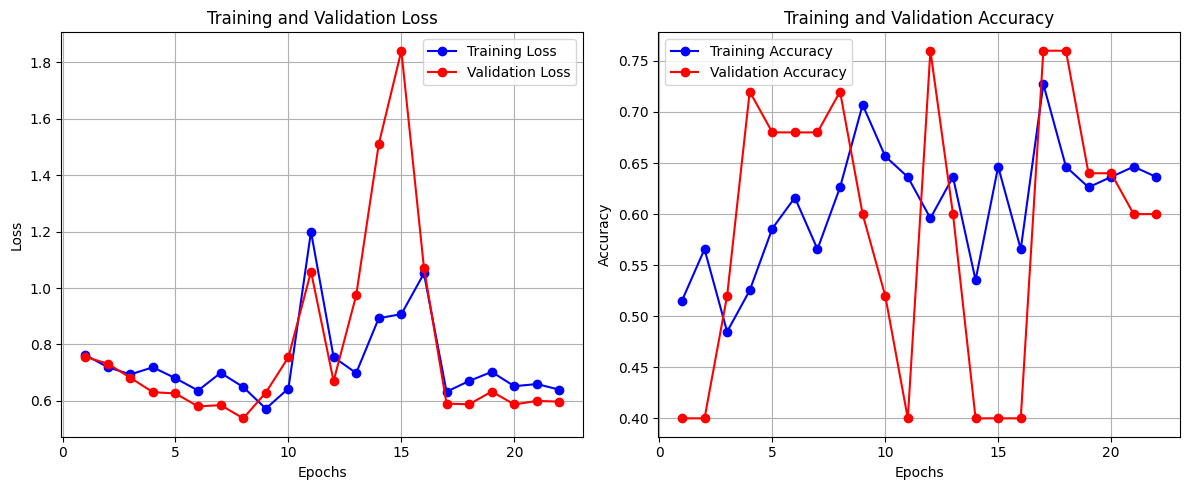

{'learning_rate': 0.7, 'epochs': 50, 'batch_size': 4, 'hidden_size': 2, 'hidden_layers': 1, 'momentum': 0.8, 'regularization': 0.0011, 'alpha': 0.01, 'patience': 10}


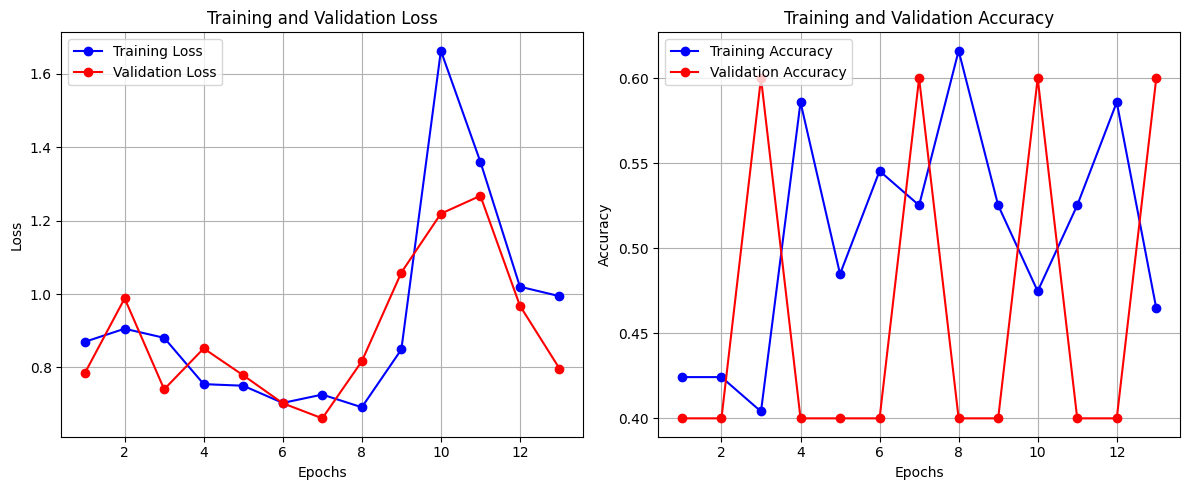

{'learning_rate': 0.5, 'epochs': 50, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.8, 'regularization': 0.0001, 'alpha': 0.01, 'patience': 10}


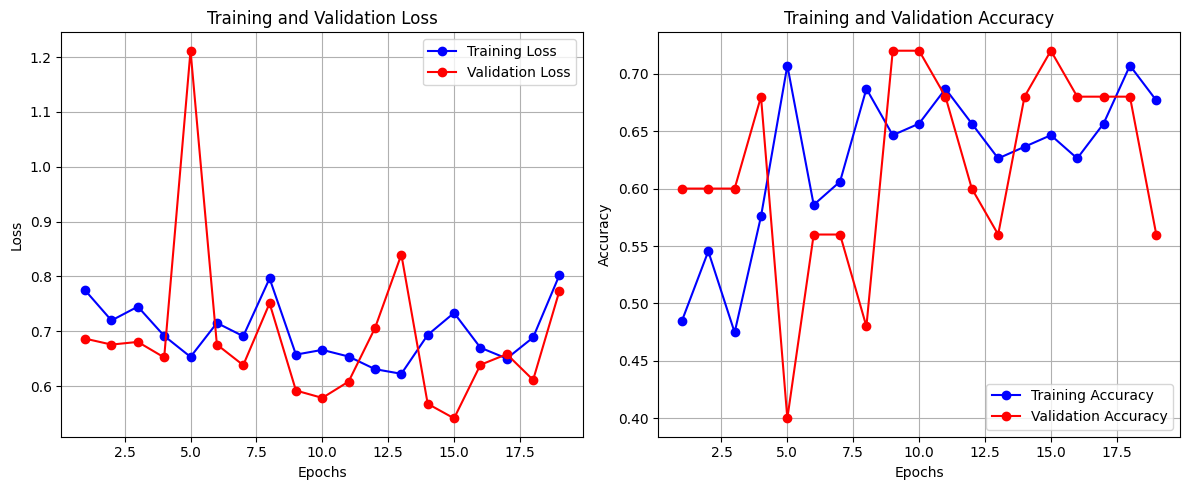

{'learning_rate': 0.7, 'epochs': 50, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.8, 'regularization': 0.0001, 'alpha': 0.01, 'patience': 10}


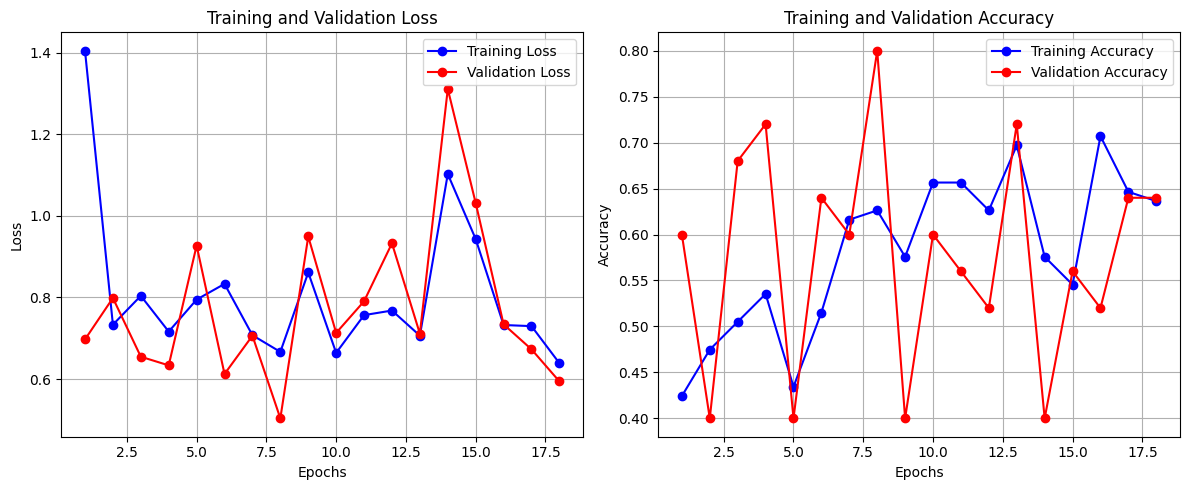

{'learning_rate': 0.7999999999999999, 'epochs': 50, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.8, 'regularization': 0.0011, 'alpha': 0.01, 'patience': 10}


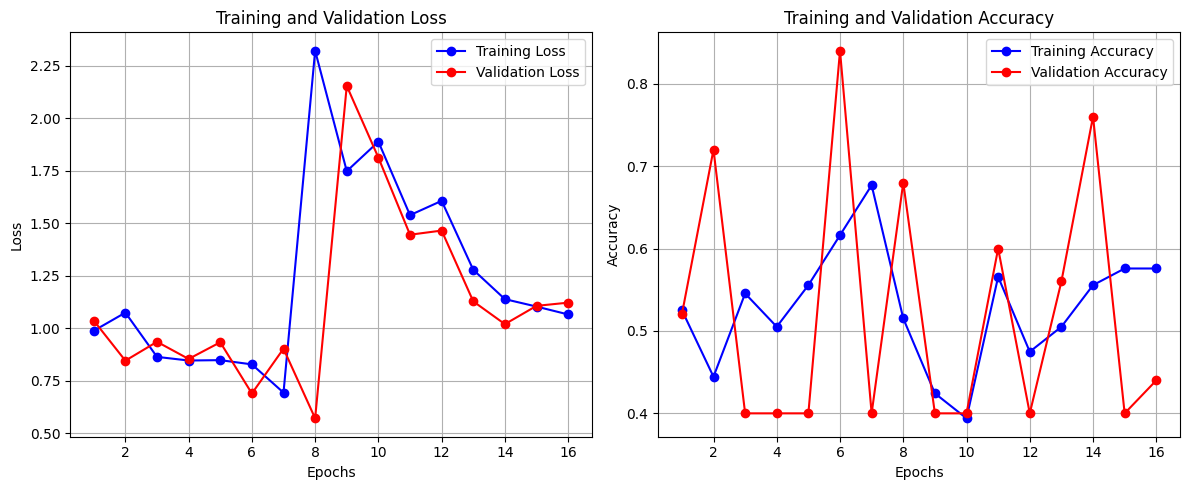

{'learning_rate': 0.7, 'epochs': 50, 'batch_size': 4, 'hidden_size': 2, 'hidden_layers': 1, 'momentum': 0.8, 'regularization': 0.0006000000000000001, 'alpha': 0.01, 'patience': 10}


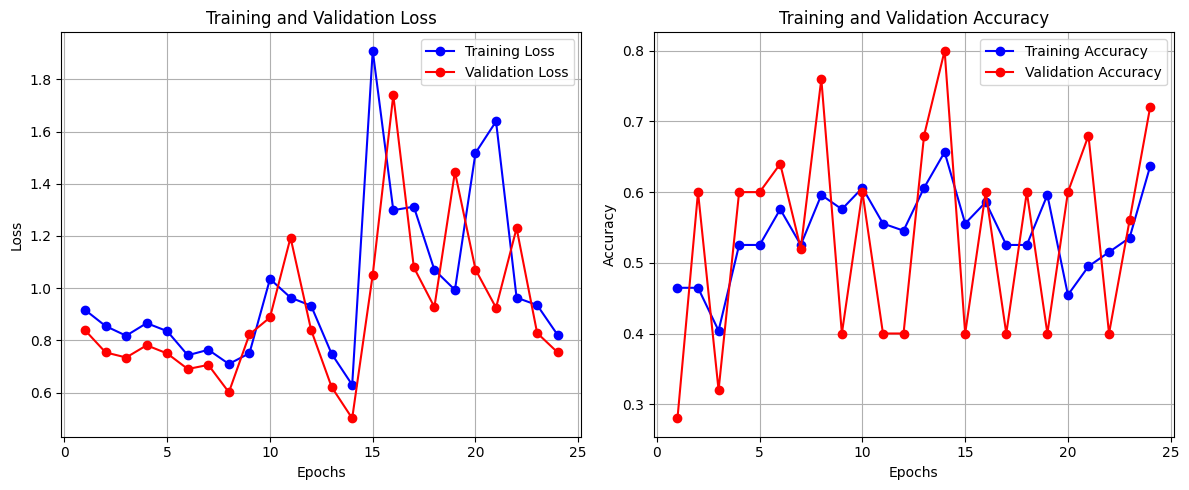

{'learning_rate': 0.7, 'epochs': 50, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.8, 'regularization': 0.0006000000000000001, 'alpha': 0.01, 'patience': 10}


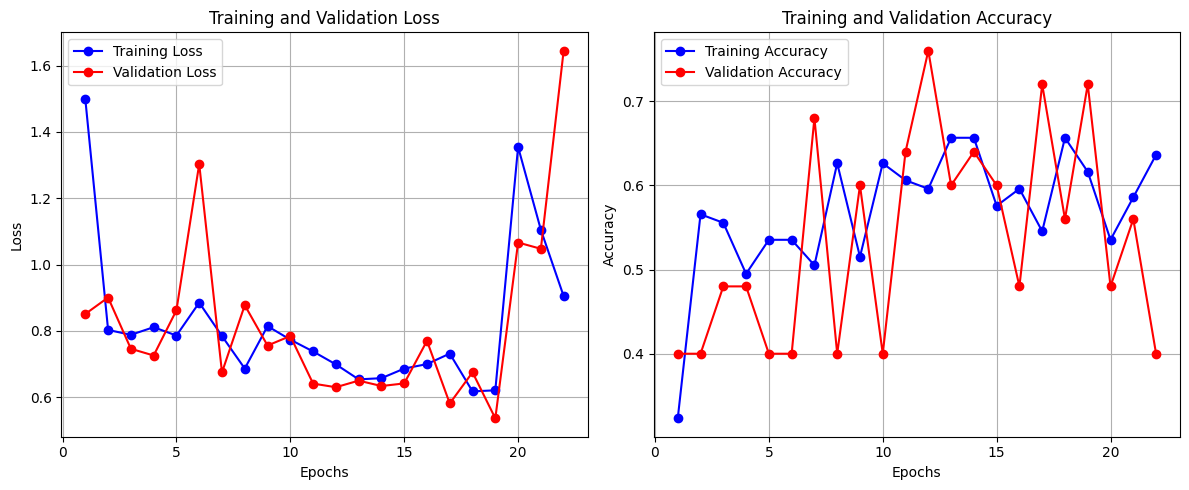

{'learning_rate': 0.6, 'epochs': 50, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.8, 'regularization': 0.0011, 'alpha': 0.01, 'patience': 10}


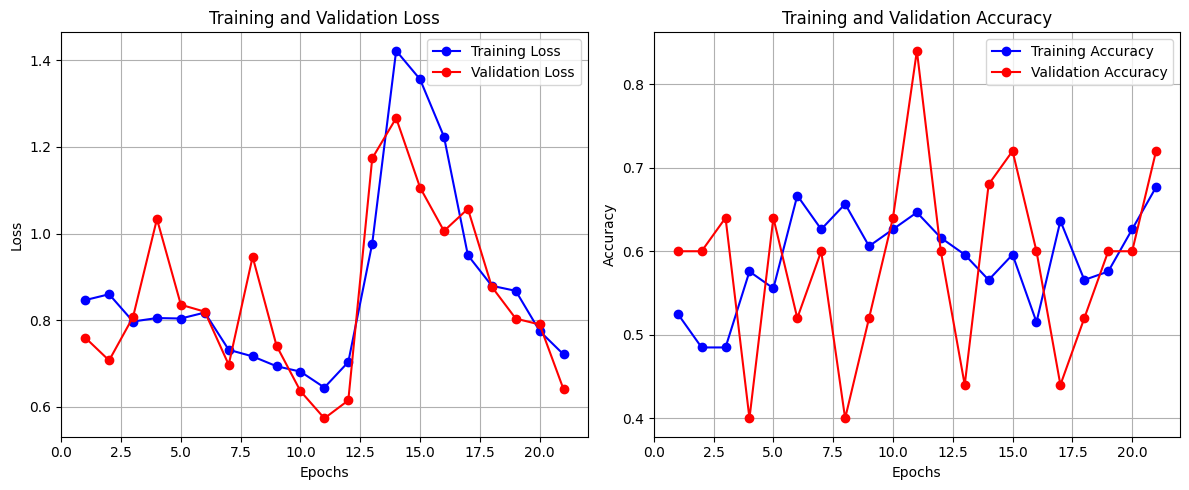

{'learning_rate': 0.6, 'epochs': 50, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.8, 'regularization': 0.0006000000000000001, 'alpha': 0.01, 'patience': 10}


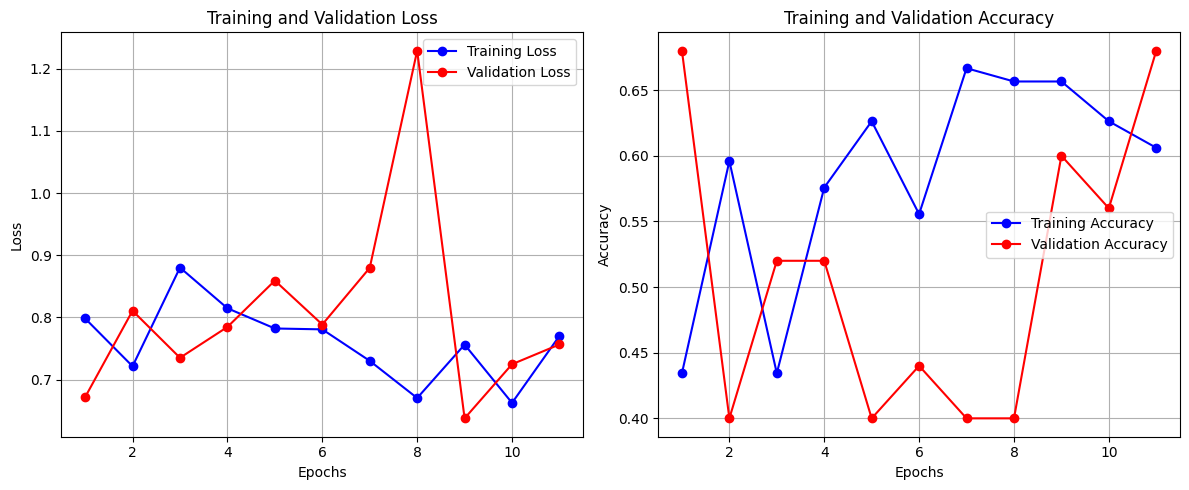

In [47]:
for i, (history, params) in enumerate(zip(best_histories, best_params_list)):
    print(f"{params}")
    plot_training_history(history)

In [48]:
best_models[0].evaluate(X1_test, y1_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6944 - auc: 0.7071 - loss: 0.8855  


[0.8657222390174866, 0.6990740895271301, 0.7512324452400208]

In [49]:
#best paramters found at the moment (Adam, regularized, relu)
# {'learning_rate': 0.6, 'epochs': 50, 'batch_size': 4, 'hidden_size': 2, 'hidden_layers': 1, 'momentum': 0.8, 'regularization': 0.0001, 'alpha': 0.01, 'patience': 10}